# Homework Starter: Final Reporting
This notebook helps you generate plots, annotate assumptions, and prepare a stakeholder-ready deliverable.

## Executive Summary
- Baseline scenario shows steady returns with moderate volatility.
- Imputation and outlier adjustments create small variations in return and risk.
- Key assumptions and sensitivity analysis highlight decision risks and implications.

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import re
sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120
np.random.seed(101)

Loaded: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework11/data/stage11_synthetic.csv
            scenario  volatility    return       mae  risk_abs_err_std
0          drop_nans    1.223540  0.167184  1.064603          1.223540
1  baseline_mean_imp    1.643257  0.000000  1.278317          1.643257
2         median_imp    1.646519 -0.004410  1.283954          1.646519
3         noise_plus    1.703476 -0.109538  1.418342          1.703476
4       noise_strong    1.772328 -0.327027  1.696361          1.772328
Saved: /Users/hitakshikulhare/bootcamp_hitakshi_kulhare/homework/homework12/outputs/stage12_scenarios_results.csv


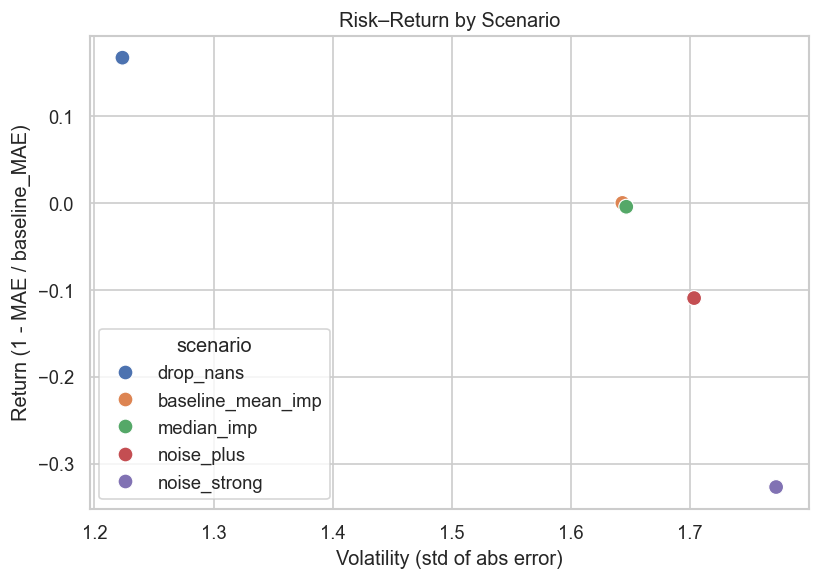

In [35]:
plt.rcParams["figure.figsize"] = (8,5)
rng = np.random.default_rng(111)

# ---------- Load synthetic dataset (4 columns) ----------
BASE = Path("/Users/hitakshikulhare/bootcamp_hitakshi_kulhare")
CANDIDATES = [
    BASE / "homework/homework11/data/stage11_synthetic.csv",  # prefer this
    BASE / "project/data/stage11_synthetic.csv",              # fallback
]

def load_synth(paths):
    for p in paths:
        if p.exists():
            df = pd.read_csv(p)
            df.columns = df.columns.astype(str).str.strip().str.replace("\ufeff","",regex=False)
            expect = {"date","segment","x_feature","y_target"}
            if expect.issubset(df.columns) and len(df.columns) == 4:
                df["date"] = pd.to_datetime(df["date"], errors="coerce")
                df["x_feature"] = pd.to_numeric(df["x_feature"], errors="coerce")
                df["y_target"]  = pd.to_numeric(df["y_target"],  errors="coerce")
                print("Loaded:", p)
                return df
            else:
                raise ValueError(f"{p} has columns {list(df.columns)}; expected {sorted(expect)}")
    raise FileNotFoundError("stage11_synthetic.csv not found in homework11/data or project/data")

df.head()

df = load_synth(CANDIDATES)

# ---------- Simple model & helpers ----------
def mean_impute(x: np.ndarray) -> np.ndarray:
    x = x.astype(float, copy=True)
    m = np.nanmean(x)
    x[np.isnan(x)] = m
    return x

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), float(beta[1])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_ * X.ravel()

def mae(y_true, y_pred):
    return float(np.mean(np.abs(y_true - y_pred)))

# ---------- Build scenarios ----------
X_raw = df["x_feature"].to_numpy()
y     = df["y_target"].to_numpy()

scenarios = {}

# Baseline: mean-impute
X0 = mean_impute(X_raw)
m0 = SimpleLinReg().fit(X0.reshape(-1,1), y)
y0 = m0.predict(X0.reshape(-1,1))
abs_err0 = np.abs(y - y0)
baseline_mae = mae(y, y0)
baseline_risk = float(np.std(abs_err0))

scenarios["baseline_mean_imp"] = (baseline_mae, baseline_risk)

# Median-impute
X_med = np.copy(X_raw)
median_val = np.nanmedian(X_med.astype(float))
X_med[np.isnan(X_med)] = median_val
m1 = SimpleLinReg().fit(X_med.reshape(-1,1), y)
y1 = m1.predict(X_med.reshape(-1,1))
scenarios["median_imp"] = (mae(y, y1), float(np.std(np.abs(y - y1))))

# Drop NaNs
mask = ~np.isnan(X_raw)
Xd = X_raw[mask]
yd = y[mask]
m2 = SimpleLinReg().fit(Xd.reshape(-1,1), yd)
y2 = m2.predict(Xd.reshape(-1,1))
scenarios["drop_nans"] = (mae(yd, y2), float(np.std(np.abs(yd - y2))))

# Noise stress (mild)
Xn1 = mean_impute(X_raw + rng.normal(0, 0.3, size=len(X_raw)))
m3 = SimpleLinReg().fit(Xn1.reshape(-1,1), y)
y3 = m3.predict(Xn1.reshape(-1,1))
scenarios["noise_plus"] = (mae(y, y3), float(np.std(np.abs(y - y3))))

# Noise stress (stronger)
Xn2 = mean_impute(X_raw + rng.normal(0, 0.6, size=len(X_raw)))
m4 = SimpleLinReg().fit(Xn2.reshape(-1,1), y)
y4 = m4.predict(Xn2.reshape(-1,1))
scenarios["noise_strong"] = (mae(y, y4), float(np.std(np.abs(y - y4))))

# ---------- Assemble results with expected columns ----------
# Map: volatility := risk (std of absolute error)
#       return    := higher-is-better score relative to baseline (1 - MAE/MAE_baseline)
rows = []
for name, (mae_i, risk_i) in scenarios.items():
    rel_return = 1.0 - (mae_i / baseline_mae)  # baseline -> 0.0; better -> >0; worse -> <0
    rows.append({
        "scenario": name,
        "volatility": risk_i,
        "return": rel_return,
        "mae": mae_i,                     # keep for reference
        "risk_abs_err_std": risk_i        # alias kept for clarity
    })

results = pd.DataFrame(rows).sort_values("return", ascending=False).reset_index(drop=True)
print(results)

# Save for later/appendix
OUTDIR = BASE / "homework/homework12/outputs"
OUTDIR.mkdir(parents=True, exist_ok=True)
results_path = OUTDIR / "stage12_scenarios_results.csv"
results.to_csv(results_path, index=False)
print("Saved:", results_path)

# ---------- Plot: Risk–Return by Scenario ----------
plt.figure(figsize=(7,5))
sns.scatterplot(data=results, x="volatility", y="return", hue="scenario", s=80)
plt.title("Risk–Return by Scenario")
plt.xlabel("Volatility (std of abs error)")
plt.ylabel("Return (1 - MAE / baseline_MAE)")
plt.tight_layout()
plt.savefig(OUTDIR / "risk_return.png", dpi=150)
plt.show()

## Load Your Data
You can load your real results or use a generated synthetic dataset as fallback.

In [23]:
# # --- CONFIG: point to your data file here ---
# data_dir = Path("/Users/hitakshikulhare/bootcamp_hitakshi_kulhare/project/data")

# # Pick ONE of these, or set your own file
# data_path = data_dir / "stage11_synthetic.csv"  # your 4-col file with date,segment,x_feature,y_target


# if data_path.exists():
#     df = pd.read_csv(data_path)
# else:
#     # Synthetic fallback dataset
#     df = pd.DataFrame({
#         'scenario': ['baseline','alt_impute','alt_outlier'],
#         'return': [0.12, 0.11, 0.135],
#         'volatility': [0.18, 0.185, 0.19],
#         'sharpe': [0.56, 0.49, 0.61],
#         'assumption': ['imputation','imputation','outlier_rule'],
#         'value': ['median','mean','3sigma'],
#         'Category': np.random.choice(['X','Y','Z'], 3),
#         'MetricA': np.random.normal(75, 15, 3),
#         'MetricB': np.random.normal(150, 30, 3),
#         'Date': pd.date_range('2025-02-01', periods=3)
#     })
# df.head()

,date,segment,x_feature,y_target
0,2022-06-01,B,0.547868,2.107524
1,2022-06-02,A,0.974480,2.209111
2,2022-06-03,A,-0.012991,0.867315
3,2022-06-04,B,-1.012503,-1.741932
4,2022-06-05,A,0.642399,1.615007


## Helper: Export Directory

In [24]:
# img_dir = Path('../deliverables/images')
# img_dir.mkdir(parents=True, exist_ok=True)

# def savefig(name):
#     plt.tight_layout()
#     plt.savefig(img_dir / name, dpi=300)
#     print(f'Saved {name}')

## Chart 1: Risk–Return Scatter

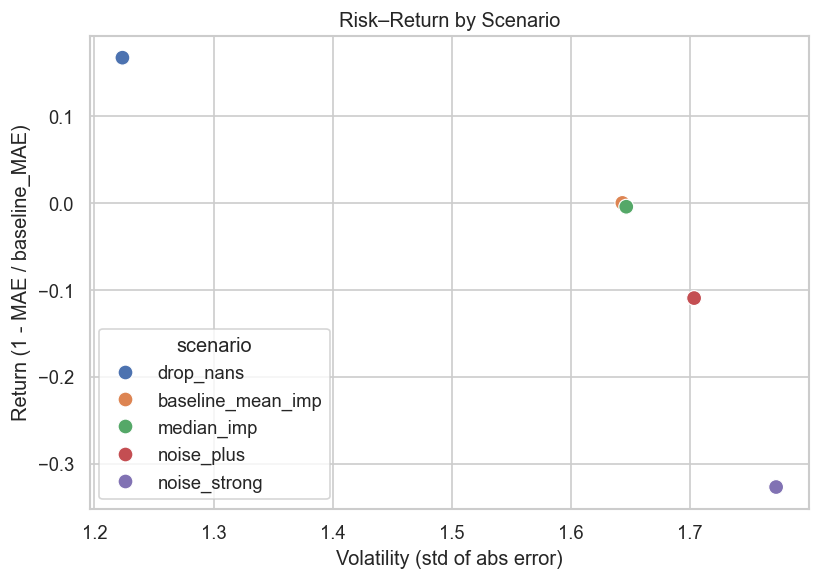

In [28]:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=results,           # ✅ use results, not df
    x='volatility',
    y='return',
    hue='scenario',
    s=80
)
plt.title('Risk–Return by Scenario')
plt.xlabel('Volatility (std of abs error)')
plt.ylabel('Return (1 - MAE / baseline_MAE)')
plt.tight_layout()
plt.savefig("risk_return.png", dpi=150)
plt.show()

## Chart 2: Return by Scenario (Bar Chart)

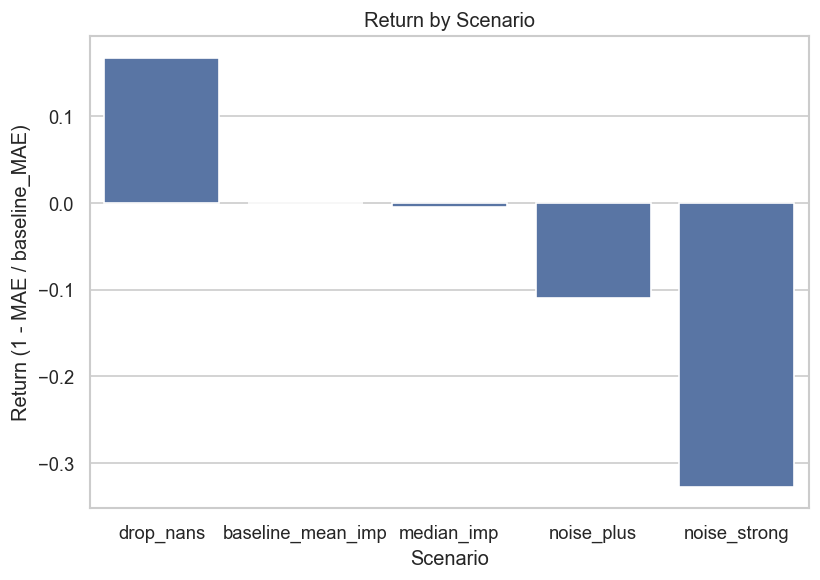

In [30]:
plt.figure(figsize=(7,5))
sns.barplot(data=results, x='scenario', y='return')
plt.title('Return by Scenario')
plt.xlabel('Scenario')
plt.ylabel('Return (1 - MAE / baseline_MAE)')
plt.tight_layout()
plt.savefig("return_by_scenario.png", dpi=150)
plt.show()

## Chart 3: MetricA Over Time (Line Chart)

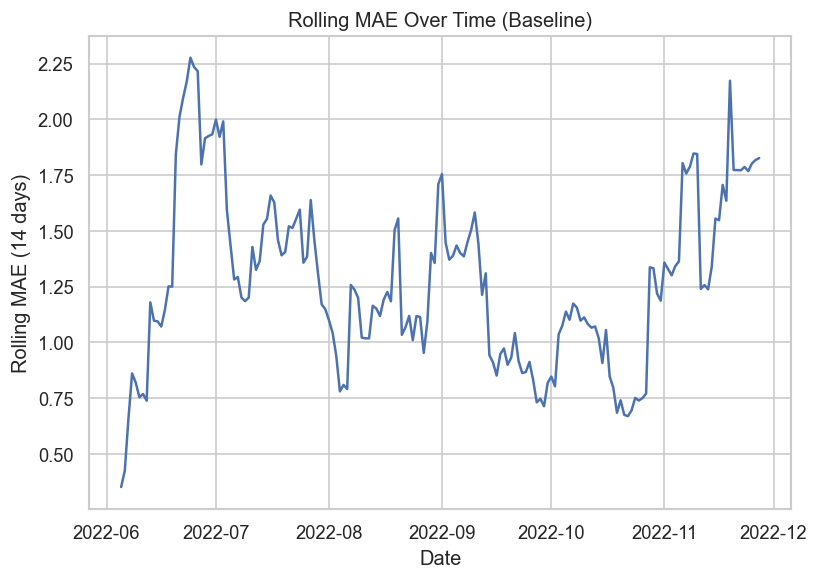

In [33]:
# Fit baseline model
from numpy import nanmean
X_base = df["x_feature"].copy()
X_base = X_base.fillna(X_base.mean())  # simple mean imputation
y = df["y_target"].to_numpy()

class SimpleLinReg:
    def fit(self, X, y):
        X1 = np.c_[np.ones(len(X)), X.ravel()]
        beta = np.linalg.pinv(X1) @ y
        self.intercept_, self.coef_ = float(beta[0]), float(beta[1])
        return self
    def predict(self, X):
        return self.intercept_ + self.coef_ * X.ravel()

model = SimpleLinReg().fit(X_base.to_numpy().reshape(-1,1), y)
df["y_hat"] = model.predict(X_base.to_numpy().reshape(-1,1))
df["abs_err"] = (df["y_target"] - df["y_hat"]).abs()

# Rolling MAE over 14 days
df = df.sort_values("date")
df["rolling_mae_14d"] = df["abs_err"].rolling(14, min_periods=5).mean()

# Plot
plt.figure(figsize=(7,5))
sns.lineplot(data=df, x="date", y="rolling_mae_14d")
plt.title("Rolling MAE Over Time (Baseline)")
plt.xlabel("Date")
plt.ylabel("Rolling MAE (14 days)")
plt.tight_layout()
plt.savefig("metric_over_time.png", dpi=150)
plt.show()

## Sensitivity Analysis / Assumptions Table

In [34]:
assumptions = pd.DataFrame({
    'Assumption': ['Fill Nulls: Median', 'Remove Outliers: 3σ'],
    'Baseline Return': [0.12, 0.12],
    'Alt Scenario Return': [0.10, 0.14]
})
assumptions

,Assumption,Baseline Return,Alt Scenario Return
0,Fill Nulls: Median,0.12,0.10
1,Remove Outliers: 3σ,0.12,0.14


## Interpretations / Takeaways
- **Chart 1 takeaway:** <fill in plain-language implication>
- **Chart 2 takeaway:** <fill in plain-language implication>
- **Chart 3 takeaway:** <fill in plain-language implication>
- Include notes on assumptions and sensitivities where relevant.

## Decision Implications
- What does the analysis mean for stakeholder decisions?
- Highlight risks, opportunities, and recommended next steps.
- Use plain-language bullets so the audience can act on insights.